(plots_intro)=
# Introduction to batteries-included plots in `arviz_plots`

In this tutorial we'll use `plot_dist` to show how to interact with the new aesthetics mapping and facetting powered by {class}`~arviz_plots.PlotCollection`,
effectively providing a first introduction to the use of `plot_...` plotting functions in `arviz_plots`.

`plot_dist` is a "batteries-included" function that plots 1D marginal distributions in the style of John K. Kruschke's _Doing Bayesian Data Analysis_ book.
It used to be called `plot_posterior`.

In [1]:
import numpy as np
import arviz_plots as azp
from arviz_base import load_arviz_data

In [2]:
azp.style.use("arviz-clean")

In [3]:
schools = load_arviz_data("centered_eight")

## Default behaviour
`plot_...` functions only have one required argument, the data to be plotted as `DataTree` (`InferenceData` representation).
These functions have a set of defaults regarding facetting, artist layout and labeling which should hopefully generate sensible figures independently of the data.

In `plot_dist`'s case, the default is to generate a grid of subplots, with as many subplots as variables and individual coordinate value combinations (after reducing the sampled dimensions). The `schools` dataset has 3 variables: `mu` and `tau` are scalar parameters of the model, and theta has an extra dimension `school` with 8 coordinate values.
Thus, a grid with $1+1+8=10$ subplots is generated:

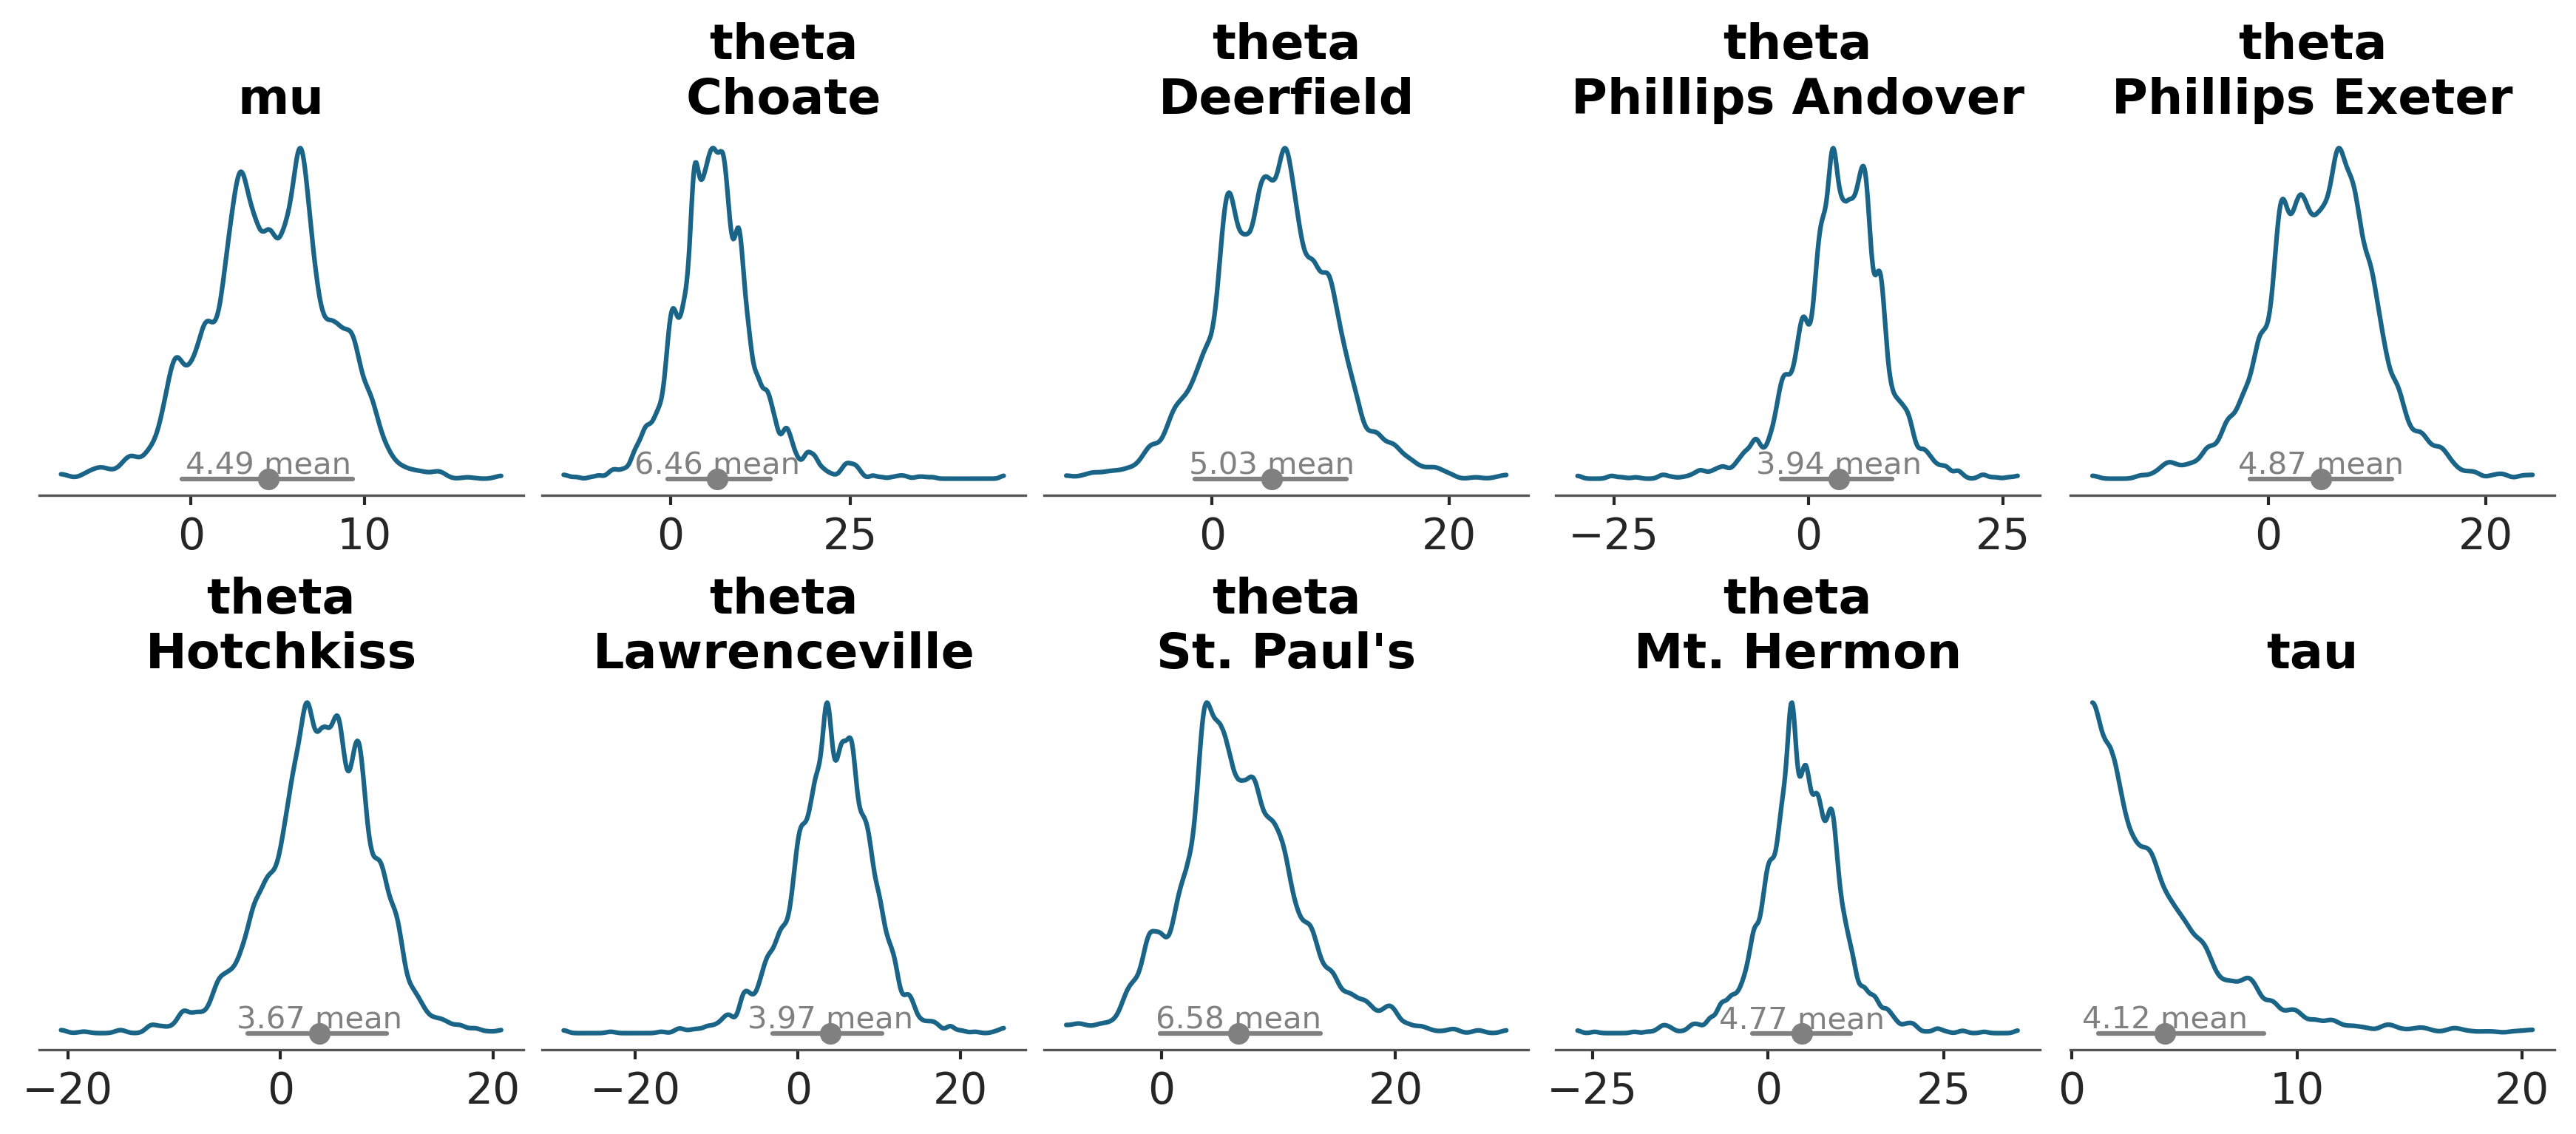

In [4]:
azp.plot_dist(schools);

As you can see, each subplot combines 3 quantities derived from the data: the probability density information (here represented with a KDE), the credible interval information (here represented with an equal tail interval) and the point estimate information (here the mean is plotted).

Each `plot_...` will have different quantities plotted, but the pattern remains the same. There are a handful of top level keyword arguments, related to data selection and general properties of the plot, and then a handful of arguments that take dictionaries that can provide finer control on the function behaviour.

In `plot_dist`'s case, the top level arguments are:
* Data selection related: `var_names`, `filter_vars`, `coords`, `group` and `sample_dims`
* General properties: `kind` to choose how to represent the probability density, `point_estimate` to choose which point estimate to use, `ci_kind` and `ci_prob` to control the credible interval, `plot_collection` in case you want to provide an existing {class}`~arviz_plots.PlotCollection` class, `backend` to choose the plotting backend and `labeller` to chose how to label each subplot.

The dictionary arguments are: `aes_map`, `plot_kwargs`, `stats_kwargs` and `pc_kwargs`. They will be introduced in a section of their own further ahead.

## `plot_kwargs`
`plot_kwargs` is a dictionary that dispatches keyword arguments through to the backend plotting functions. Its keys should be graphical elements and its values should be dictionaries that are passed as is to the plotting functions. The docstrings of each `plot_...` function indicate which are the valid top level keys and where is each dictionary value dispatched to.

As you can see in its docstring, {func}`~arviz_plots.plot_dist` has 5 valid keys: kde, credible_interval, point_estimate, point_estimate_text and title.

We can use it to change the color of the KDE line:

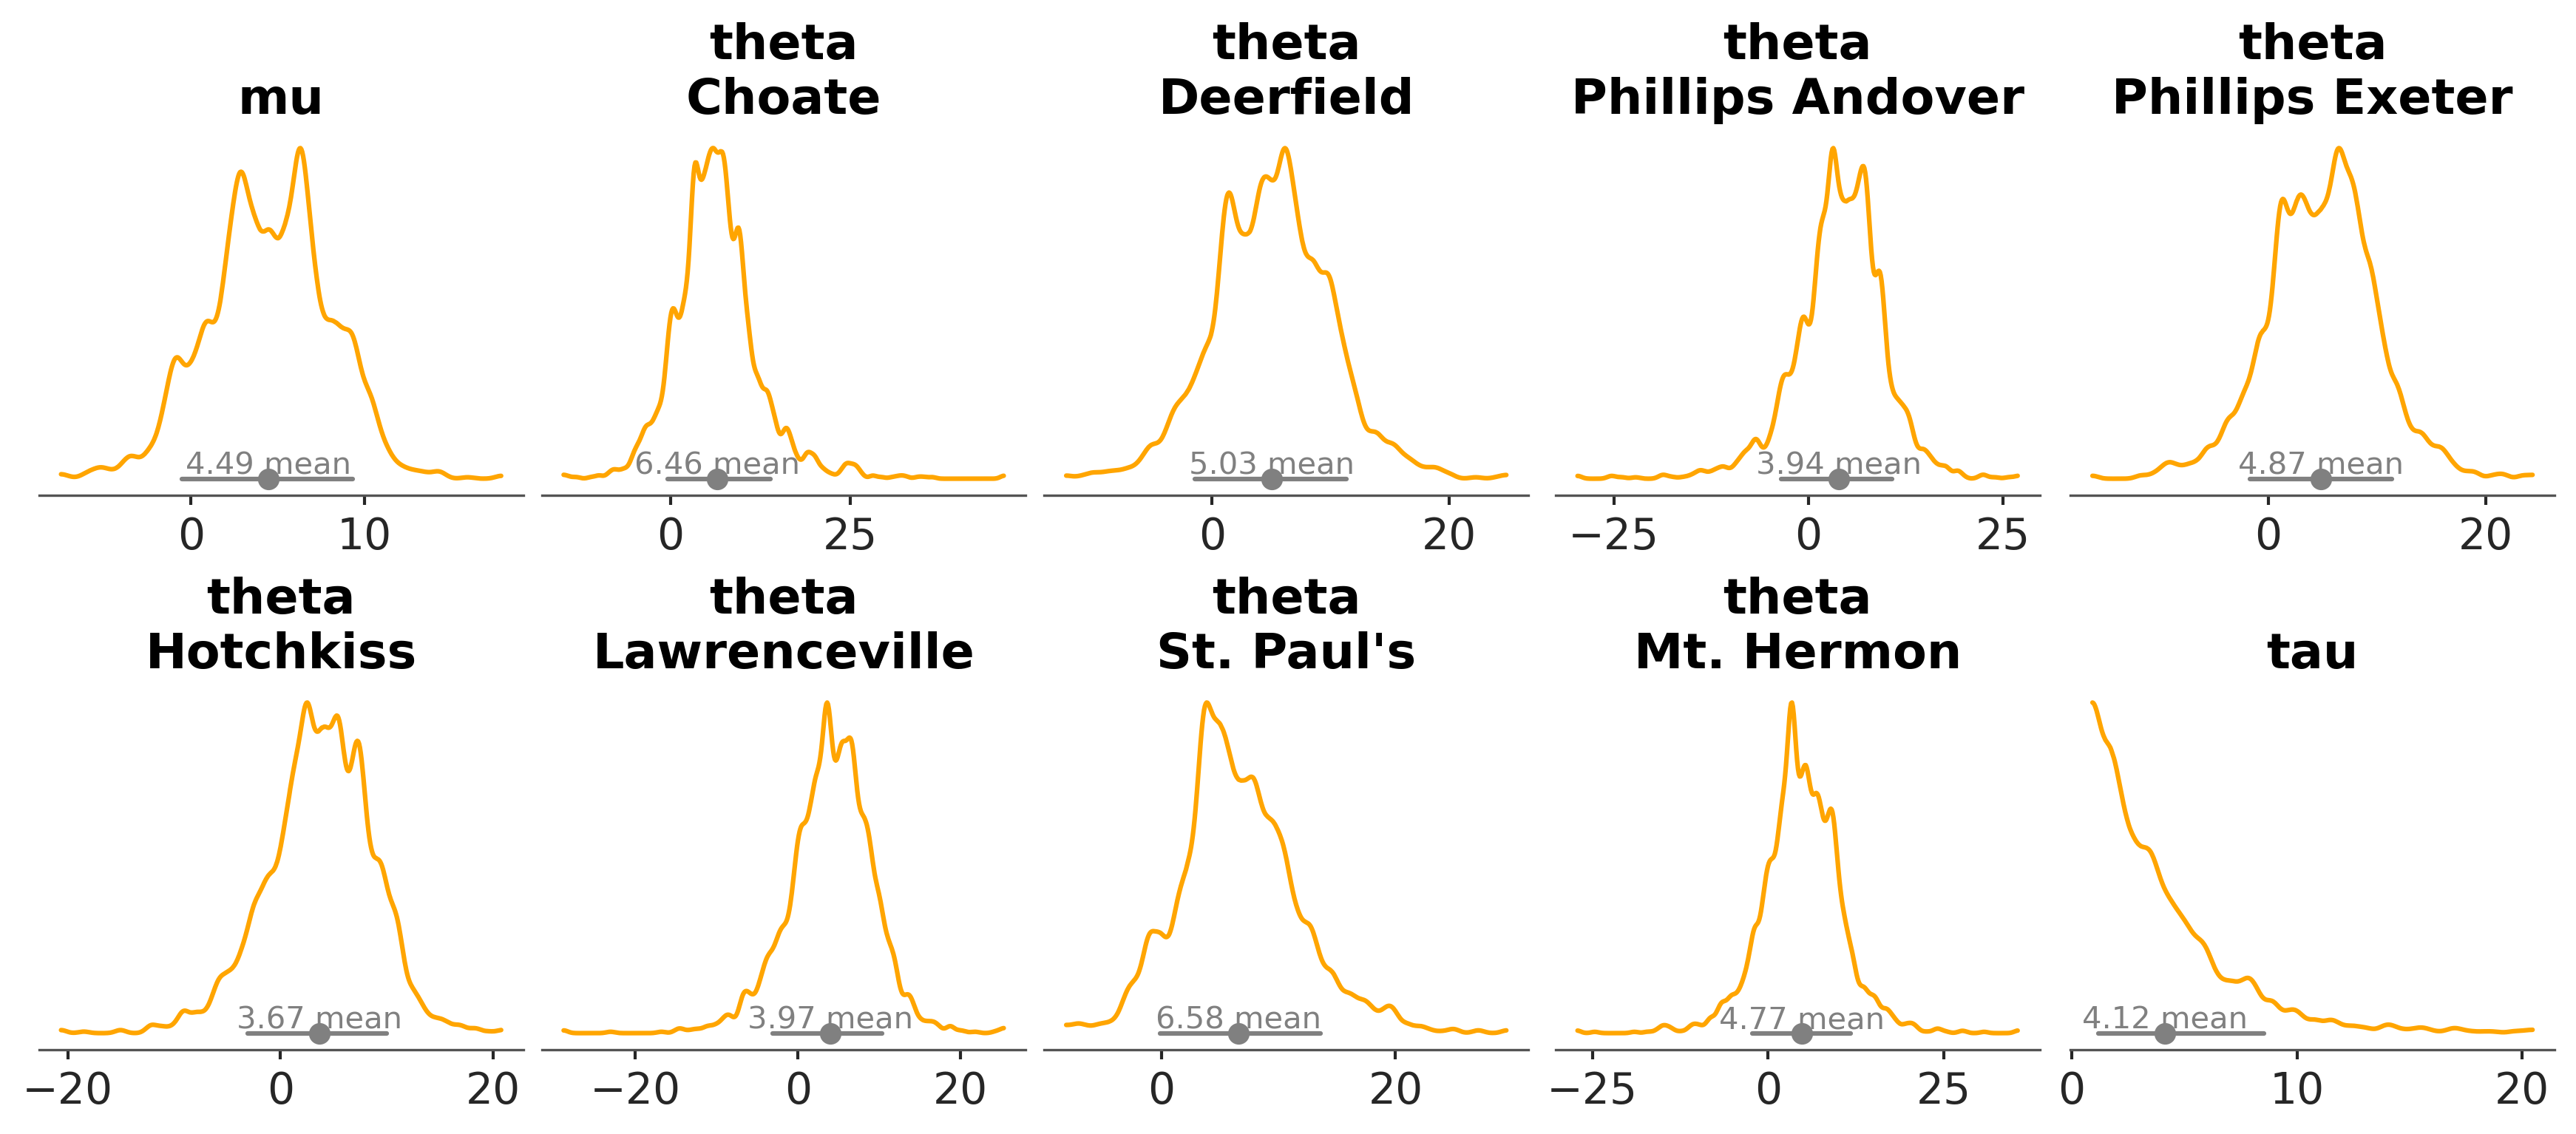

In [5]:
azp.plot_dist(schools, plot_kwargs={"kde": {"color": "orange"}});

Or to change the color and linestyle of the credible interval together with the fonts of the point estimate annotation and title:

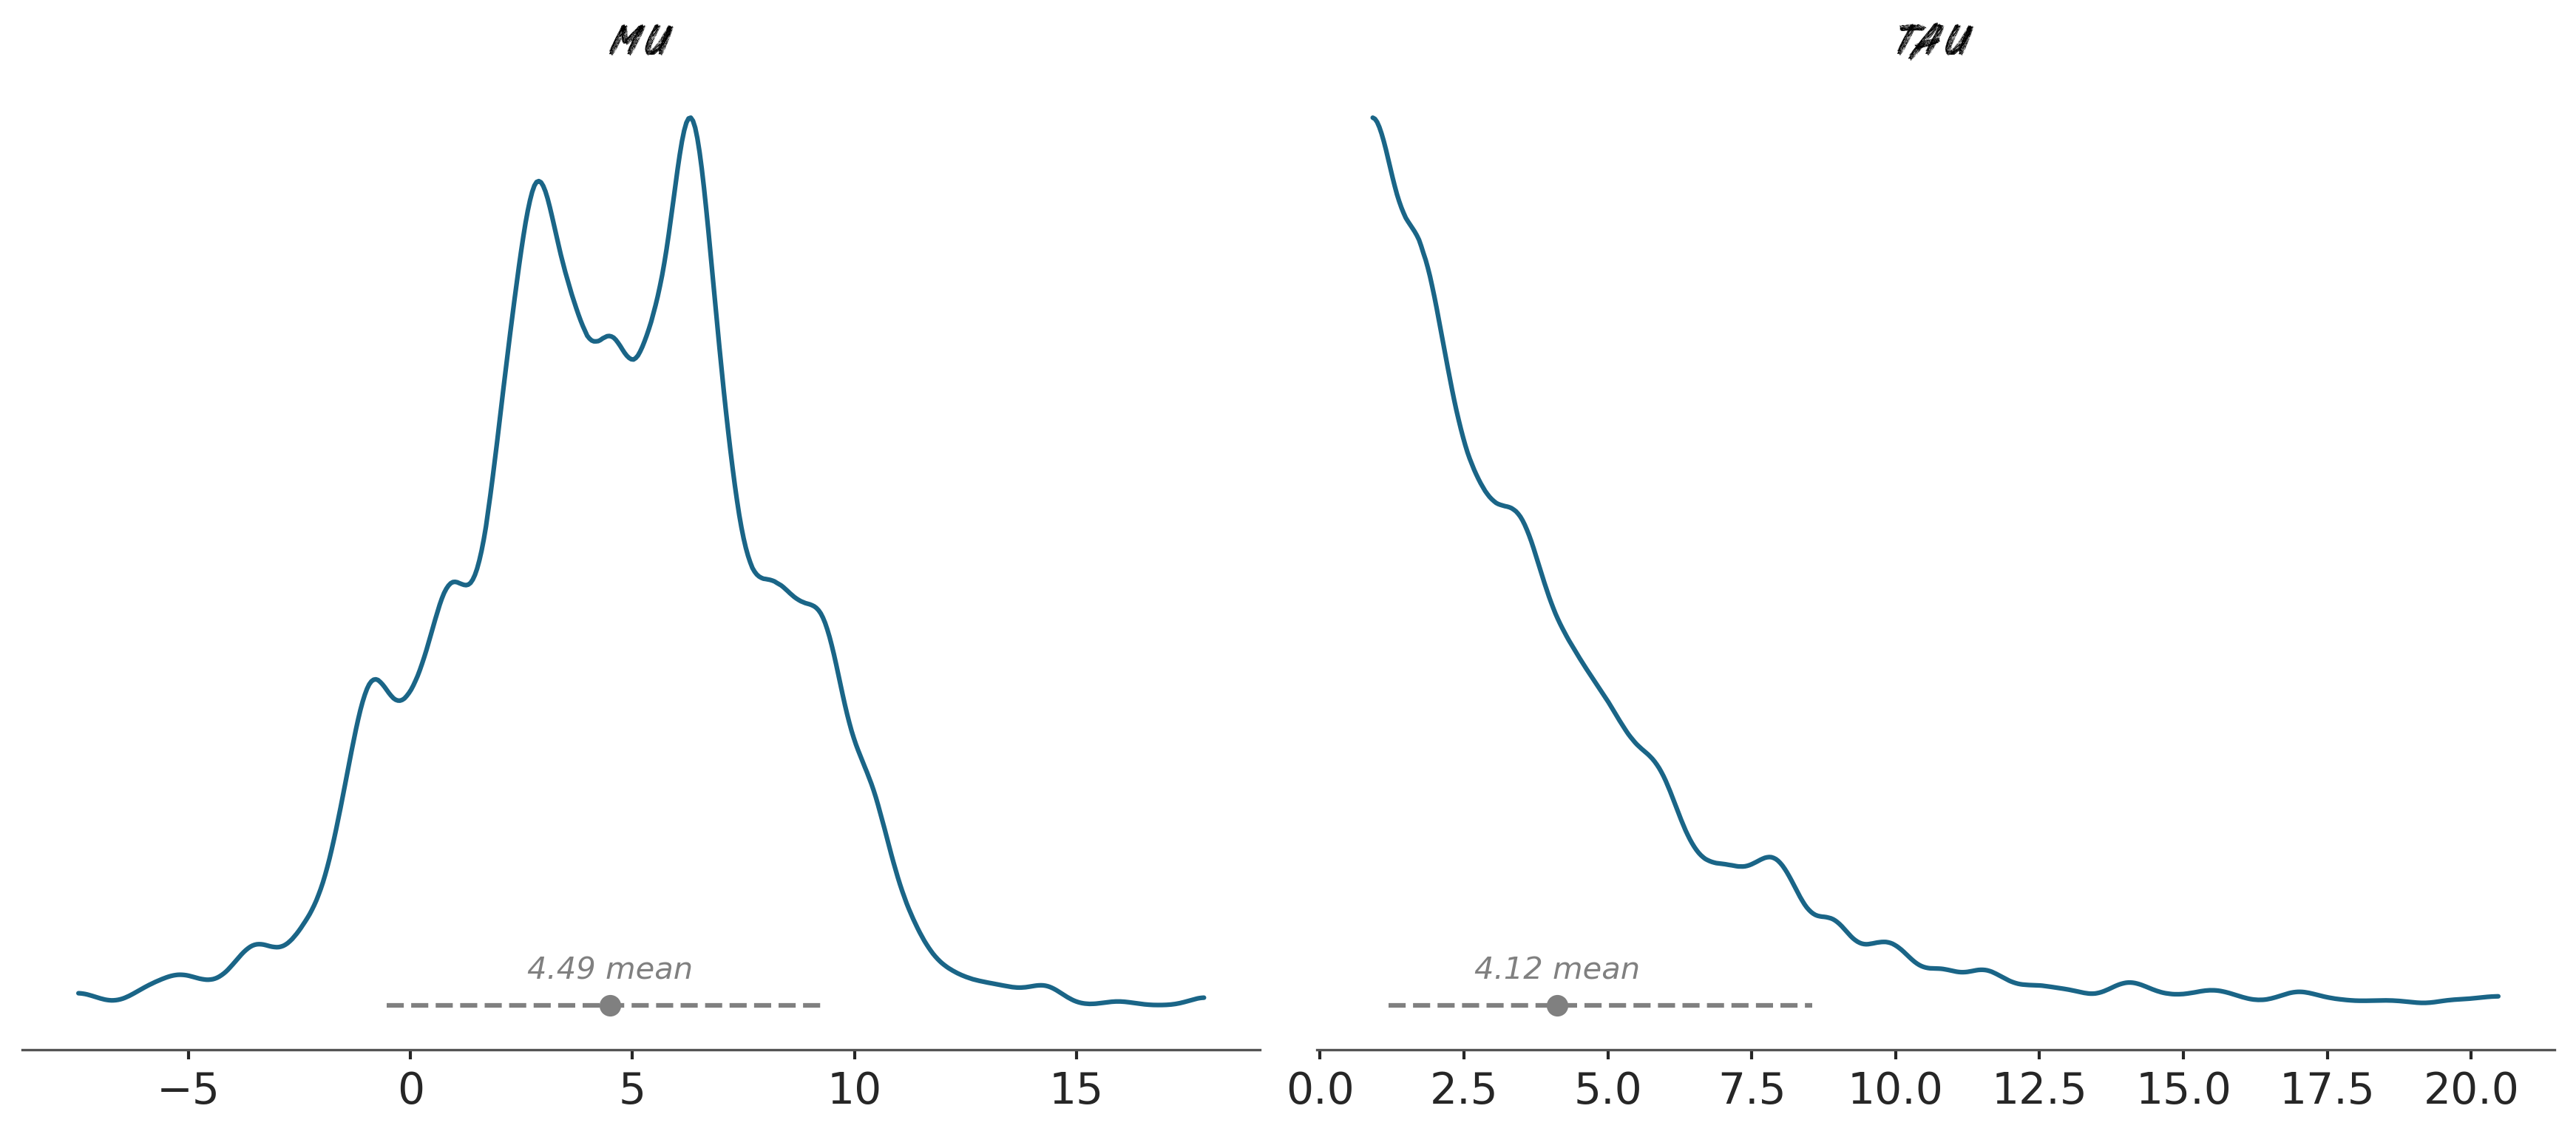

In [6]:
azp.plot_dist(
    schools,
    var_names=["mu", "tau"],
    plot_kwargs={
        "credible_interval": {"linestyle": "--"},
        "point_estimate_text": {"fontstyle": "italic"},
        "title": {"fontfamily": "Charcoal"}
    }
);

## `stats_kwargs`
`stats_kwargs` is a dictionary that dispatches keyword arguments through to the statistical computation function.

In `plot_dist` we can use it for example to control the kde computation and modify the bandwidth selection algorithm:

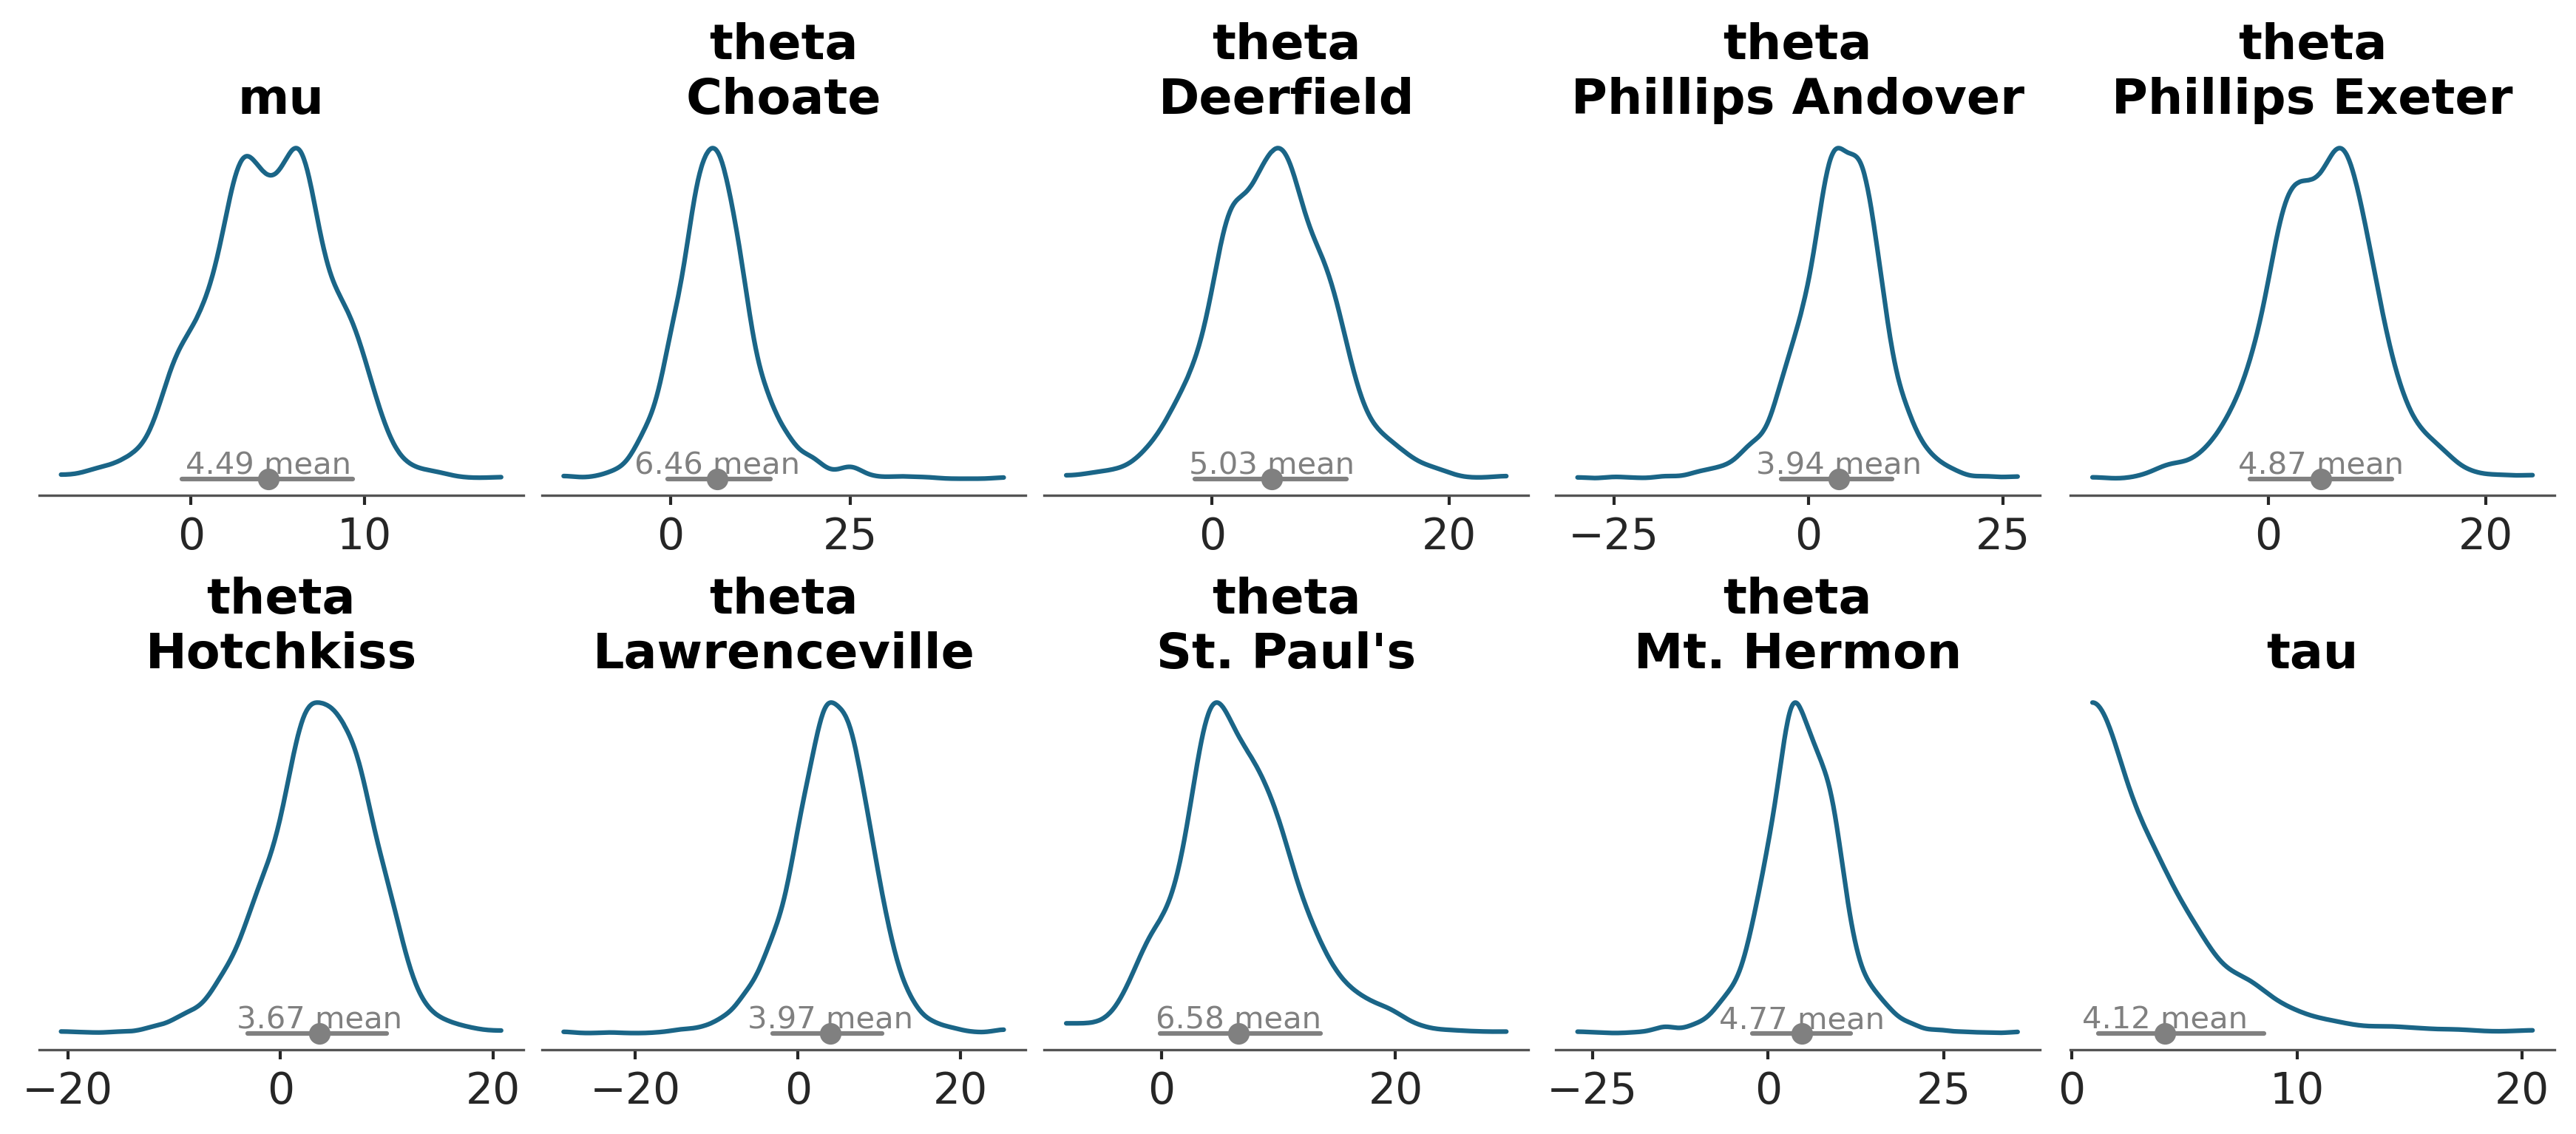

In [7]:
azp.plot_dist(schools, stats_kwargs={"density": {"bw": "scott"}});

## `pc_kwargs` and `aes_map`
`pc_kwargs` are passed to {meth}`arviz_plots.PlotCollection.wrap` to initialize the `PlotCollection` object that takes care of facetting and aesthetics mapping, and to generate and manage the chart. With it we can regulate from the figure size or sharing of axis limits, to modifying completely the layout and aesthetics of the generated plot.

Thus, each chart has a set of mappings between dataset properties and graphical properties. For example, we might encode the `school` information (dataset property) with the color (graphical property). And these mappings are shared between all subplots and between all graphical elements. `aes_map` regulates which mappings apply to which graphical elements; by default, mappings only apply to the density representation.

We can start by defining an aesthetics mapping:

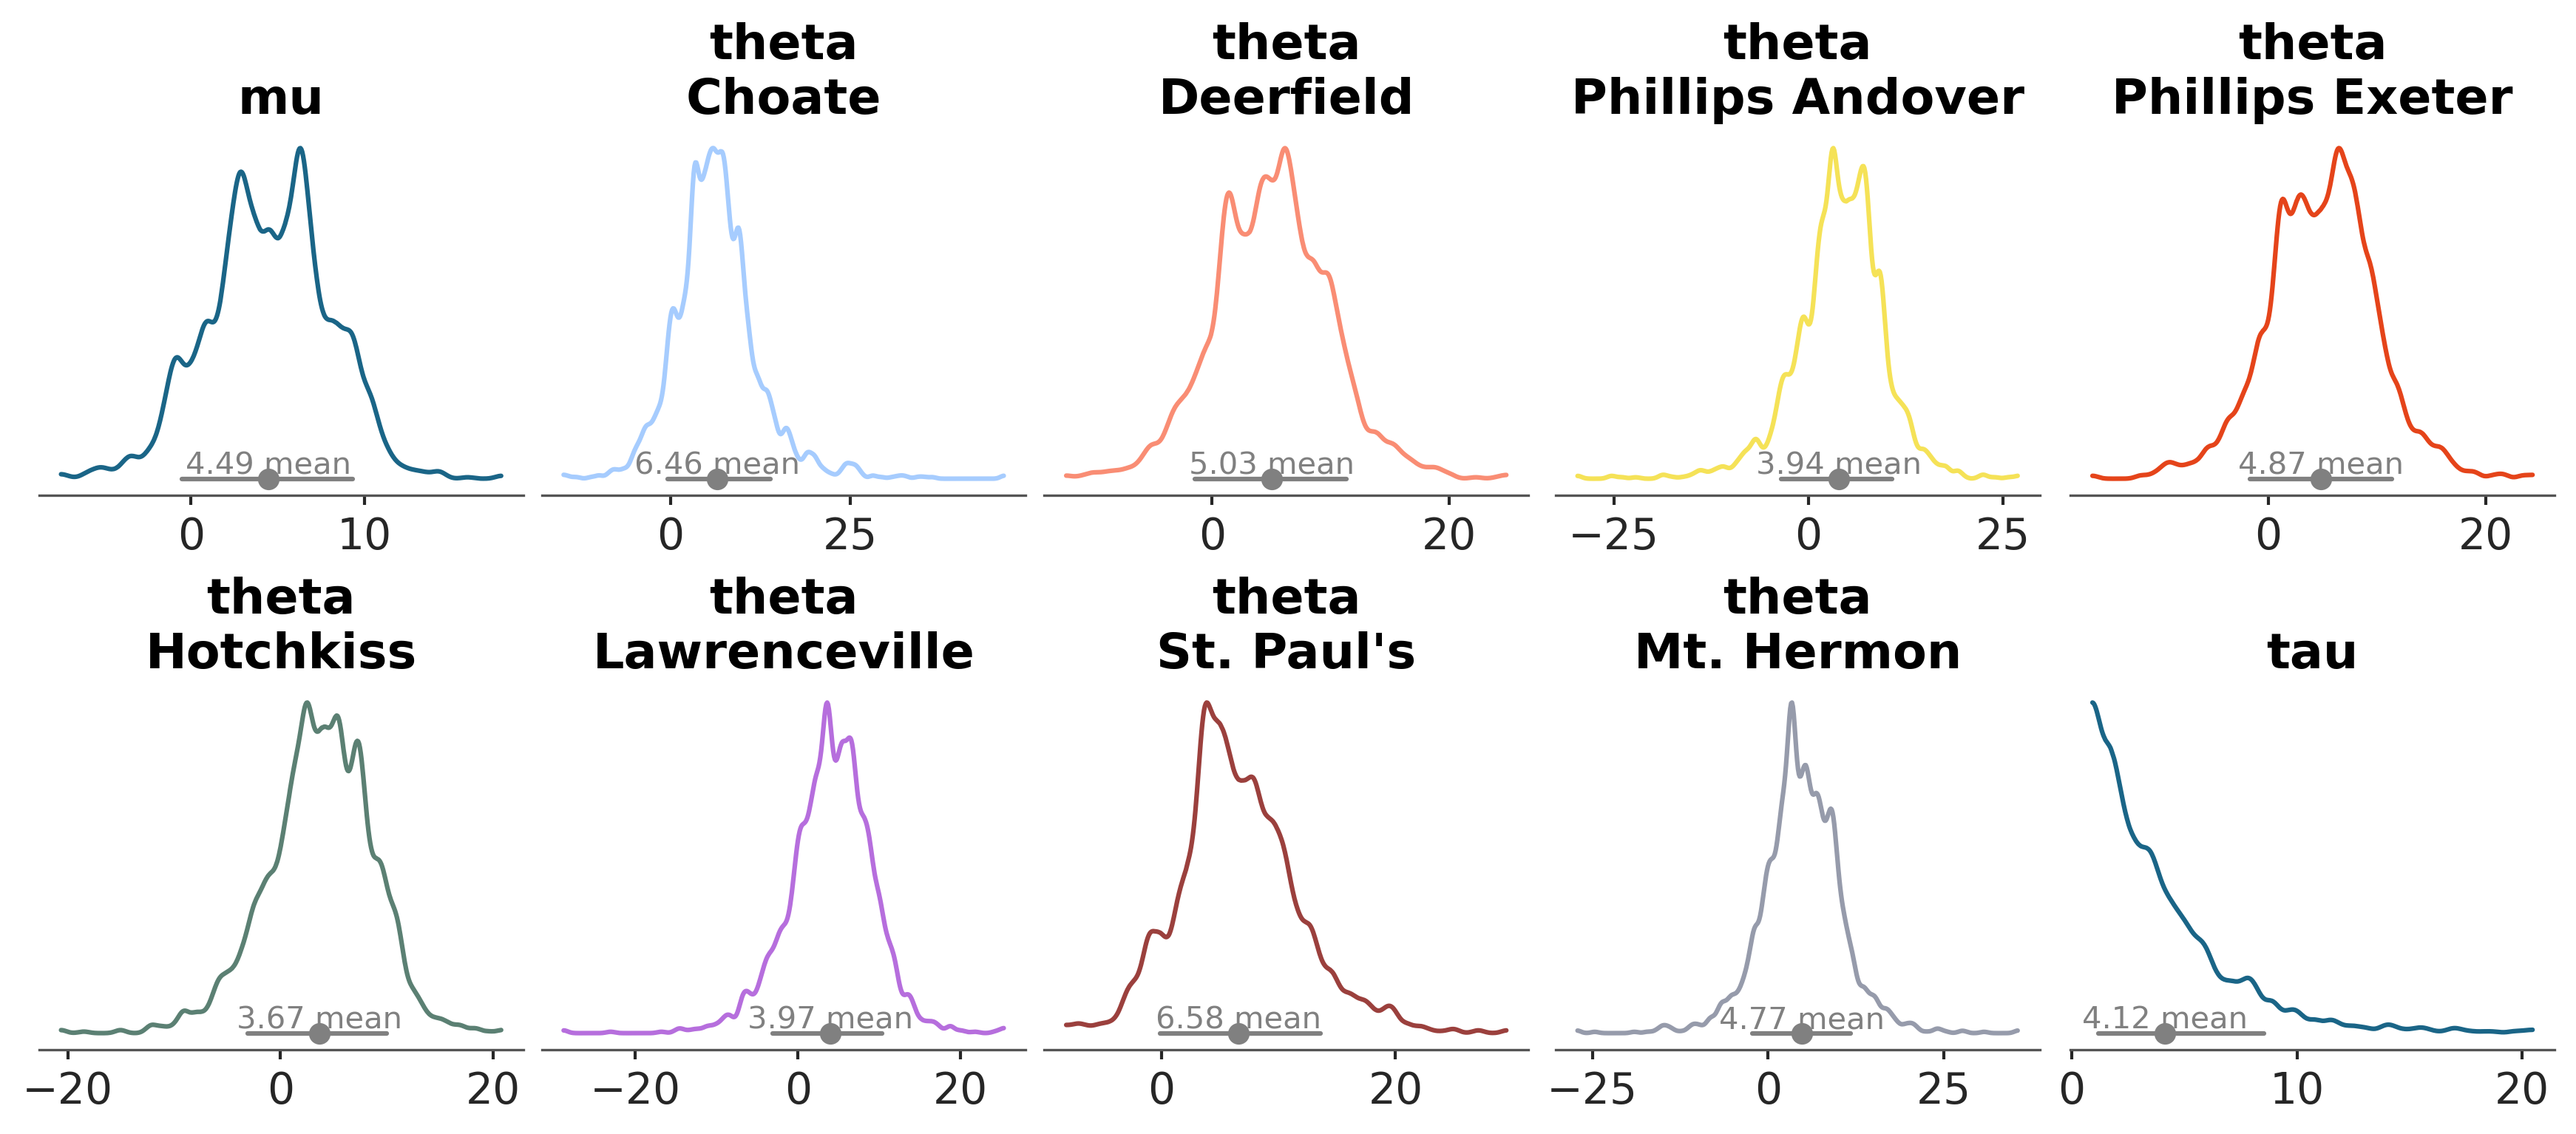

In [8]:
azp.plot_dist(
    schools,
    pc_kwargs={
        # encode the school information in the color property
        "aes": {"color": ["school"]},
    }
);

Note that `mu` and `tau` have a common color, which is different to any of the `theta` lines. As they don't have the `school` dimension, `PlotCollection` then takes
the first element in the aesthetic (in this case "C0", the first color of the matplotlib color cycle) as _neutral element_, then generates a mapping excluding that element.
The _neutral element_ is therefore reserved to be used when the mapping can't be applied _and only then_.

Then configuring where it is applied to:

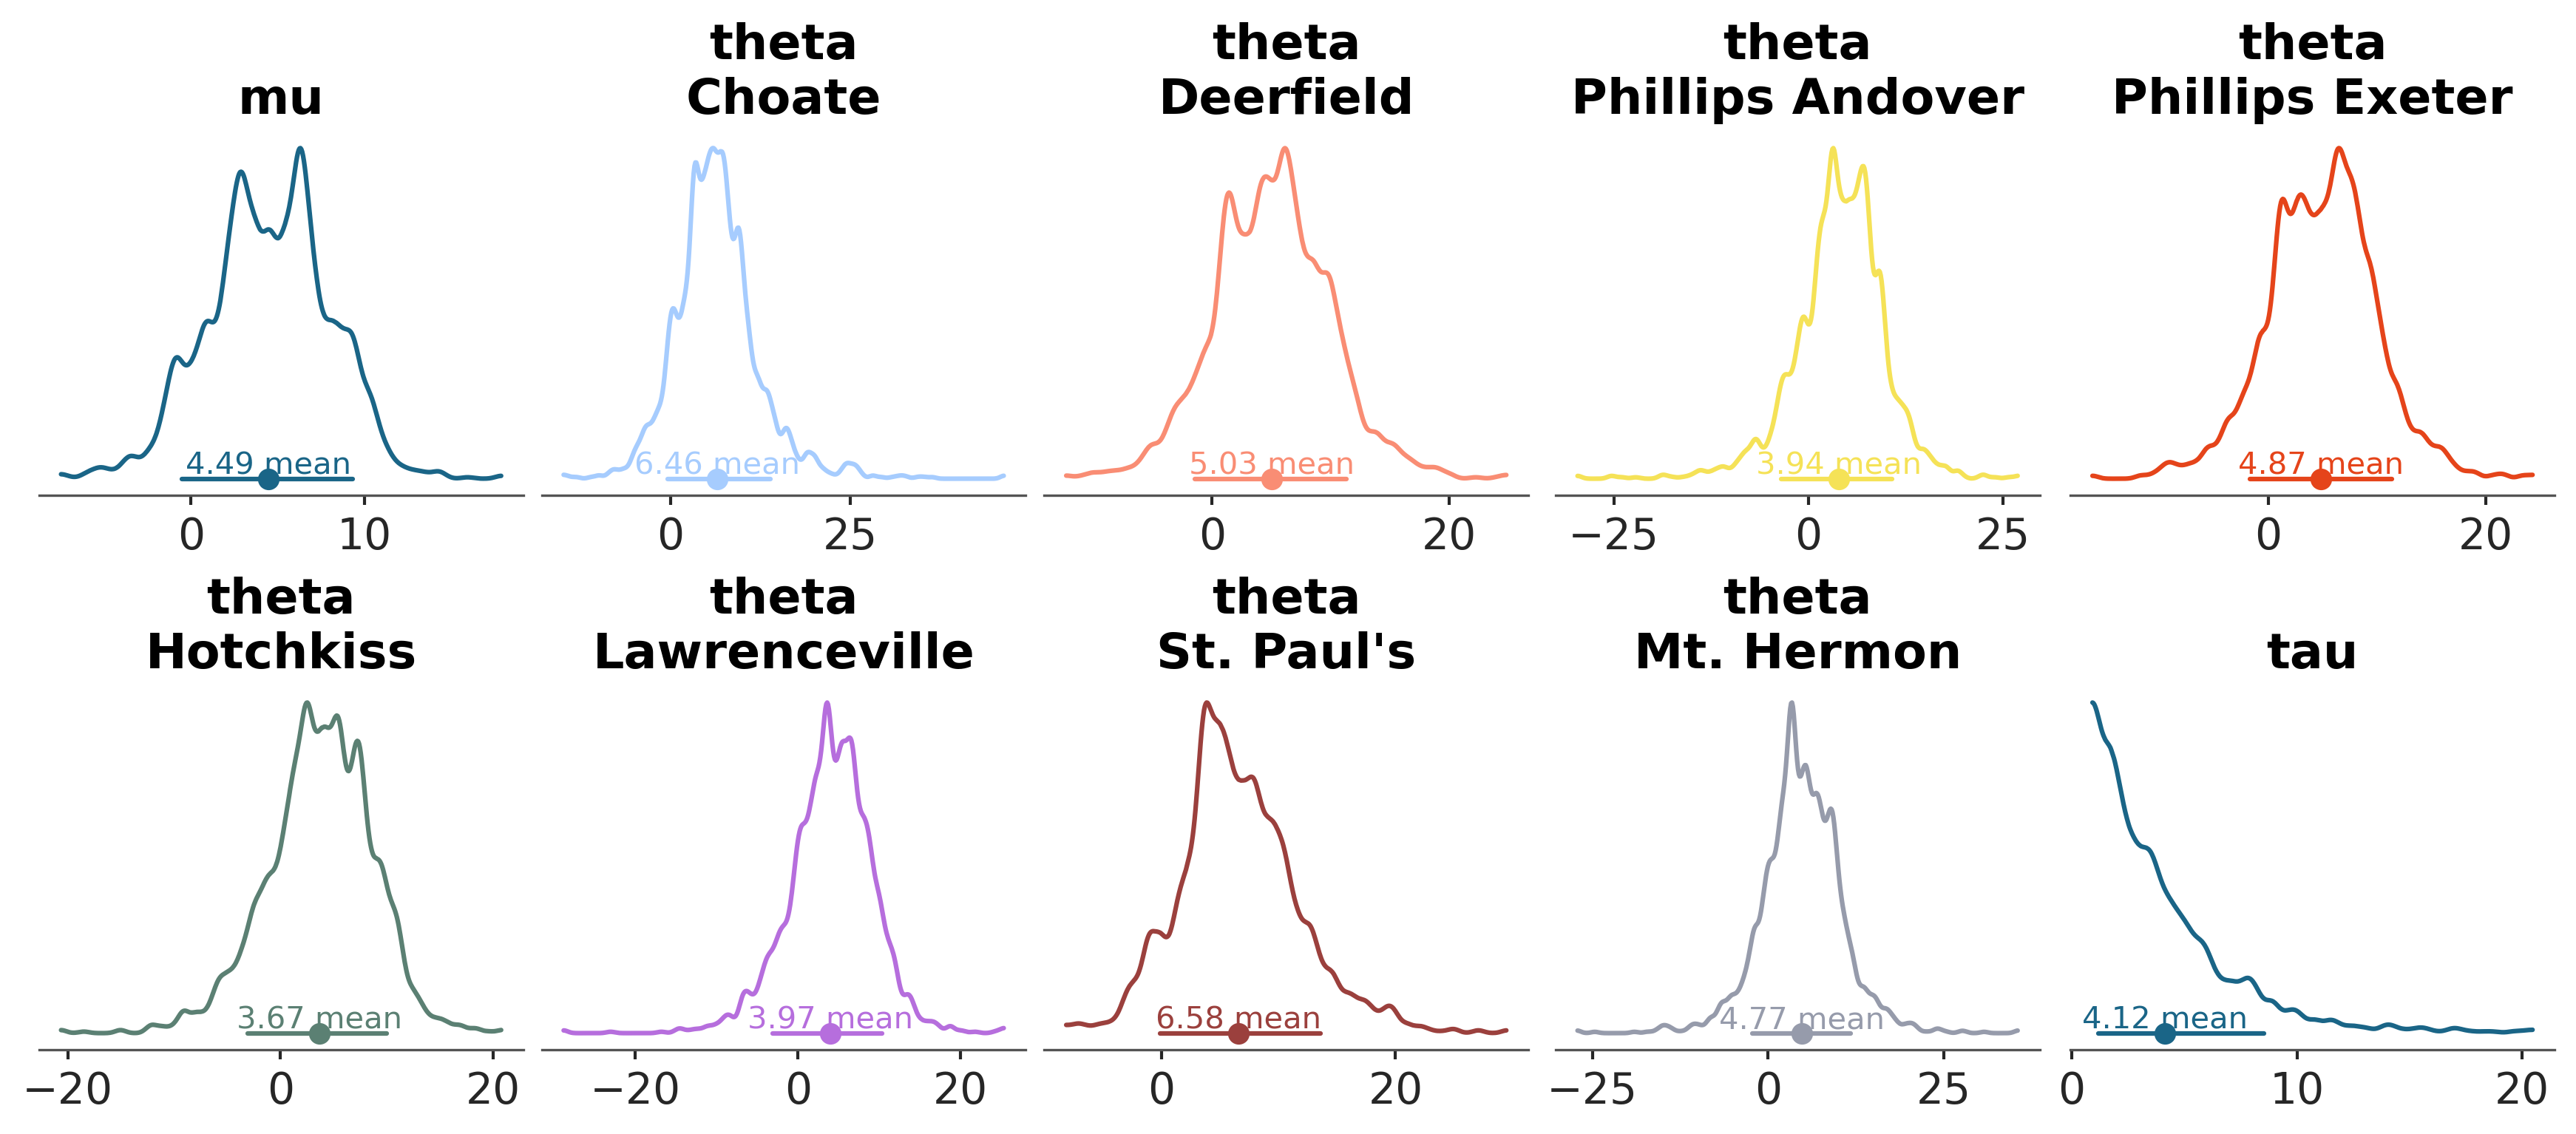

In [9]:
azp.plot_dist(
    schools,
    pc_kwargs={"aes": {"color": ["school"]}},
    # apply the color-school mapping to all graphical elements but the title
    aes_map={
        "kde": ["color"],
        "point_estimate": ["color"],
        "credible_interval": ["color"]
    }
);

We can have as many aesthetics mapping as desired, and map all of them, none or a subset of them to the different graphical elements:

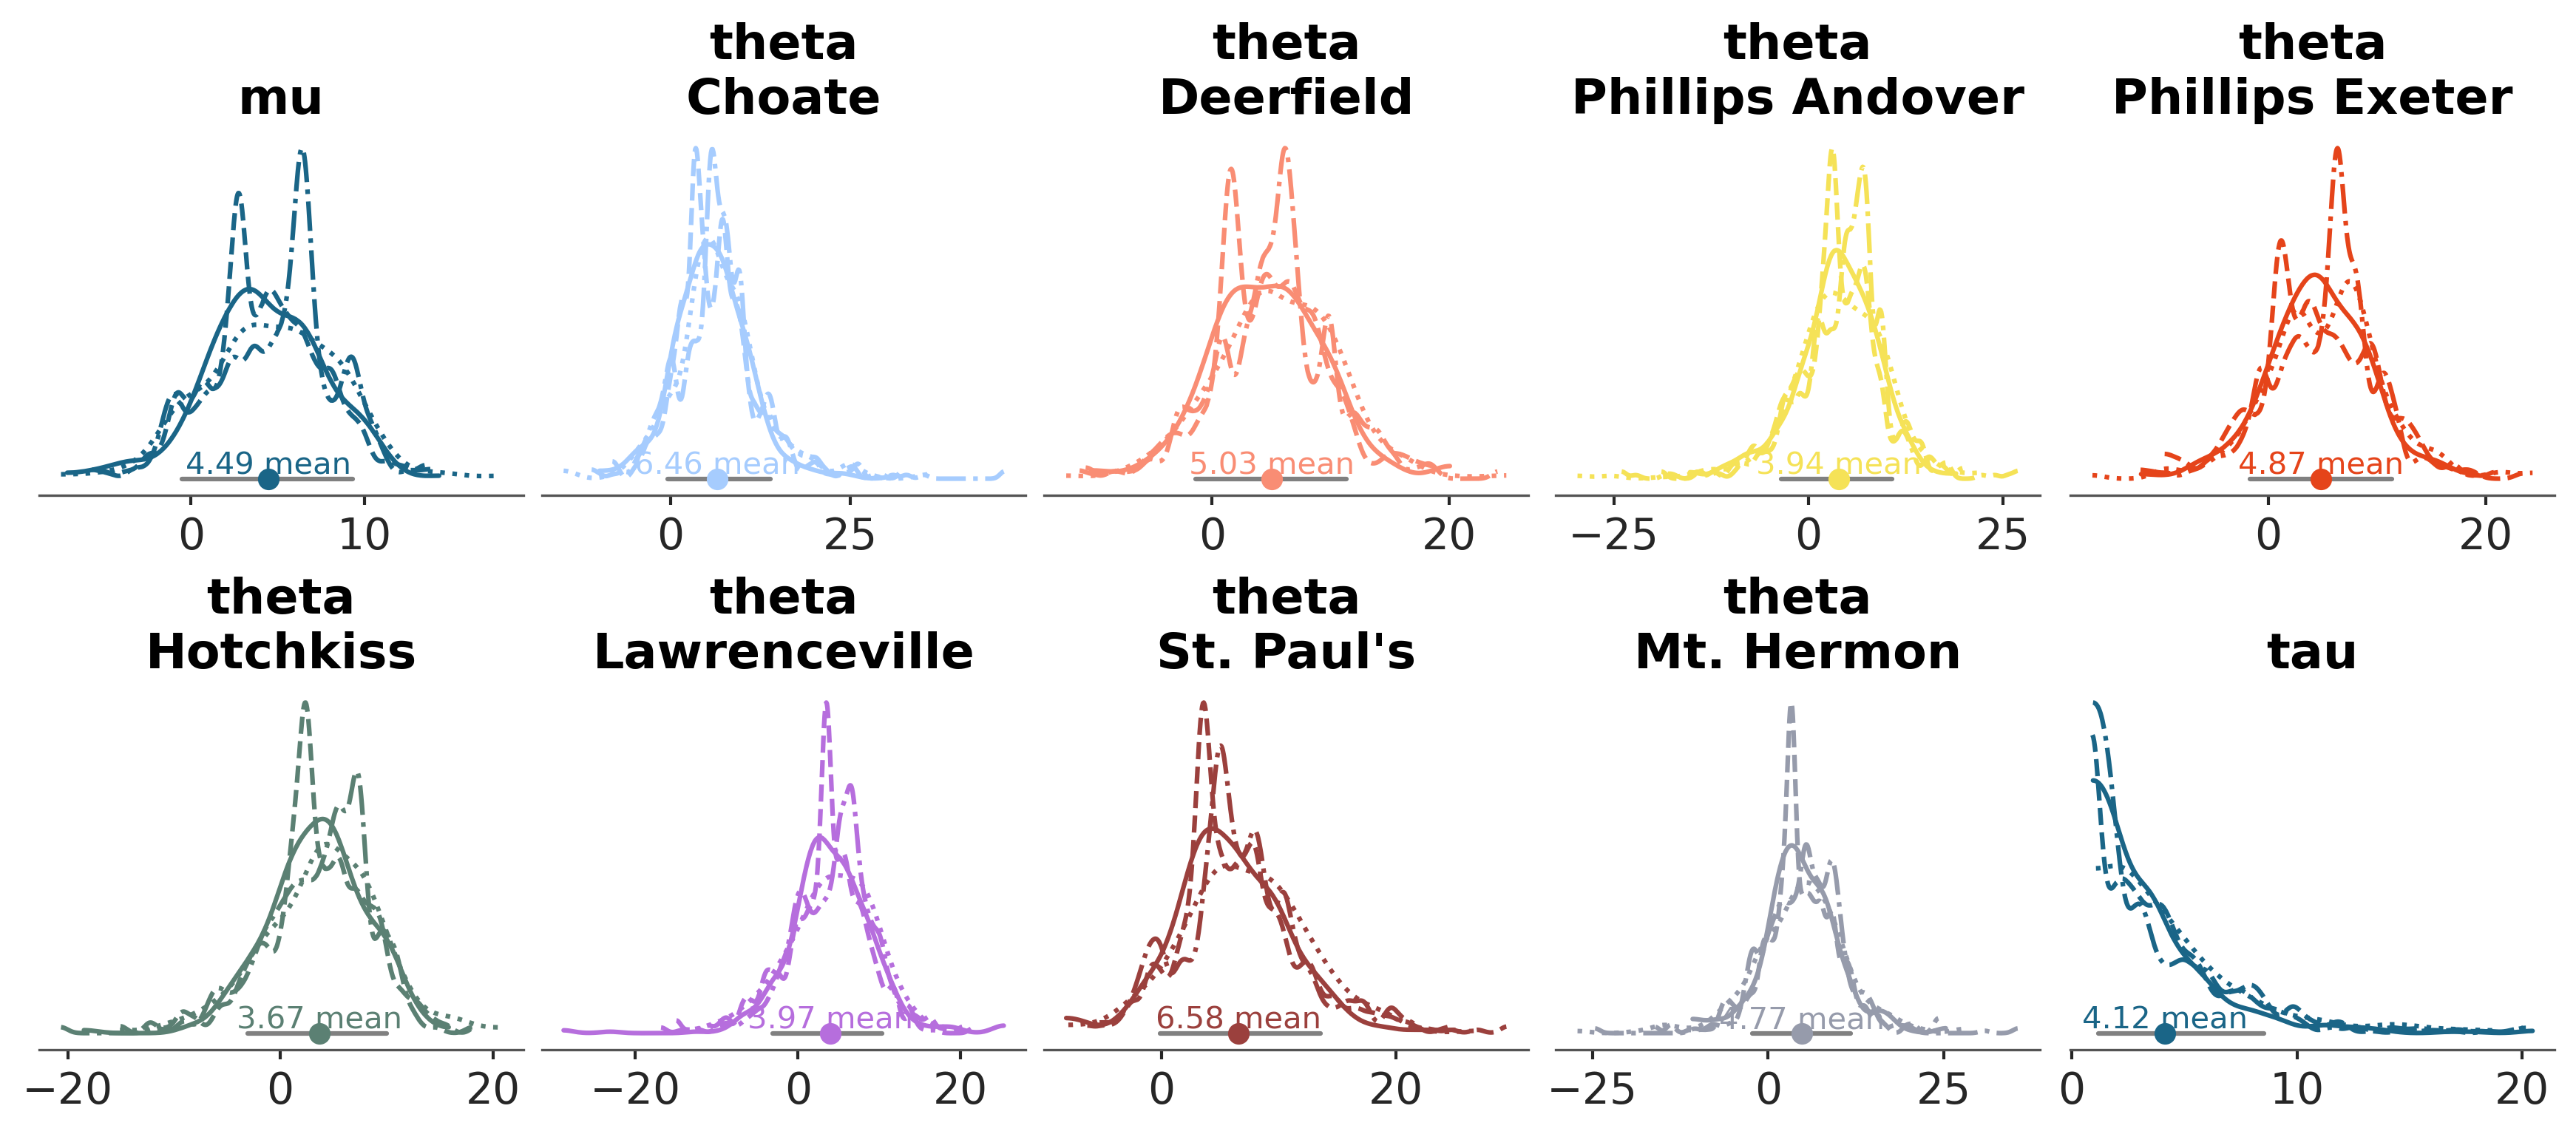

In [10]:
azp.plot_dist(
    schools, 
    pc_kwargs={
        "aes": {"color": ["school"], "linestyle": ["chain"]},
        "plot_grid_kws": {"figsize": (12, 7)}
    },
    aes_map={"kde": ["color", "linestyle"], "point_estimate": ["color"]},
);

Note that now there is an aesthetic (linestyle) mapped to the `chain` dimension. Therefore, `PlotCollection` now loops over the `chain` dimension in order to enforce the aesthetic mapping, generating now 4 kde lines in each plot.

Legends are not automatic, but can be generated by the `PlotCollection` class which is returned by all `plot_...` functions:

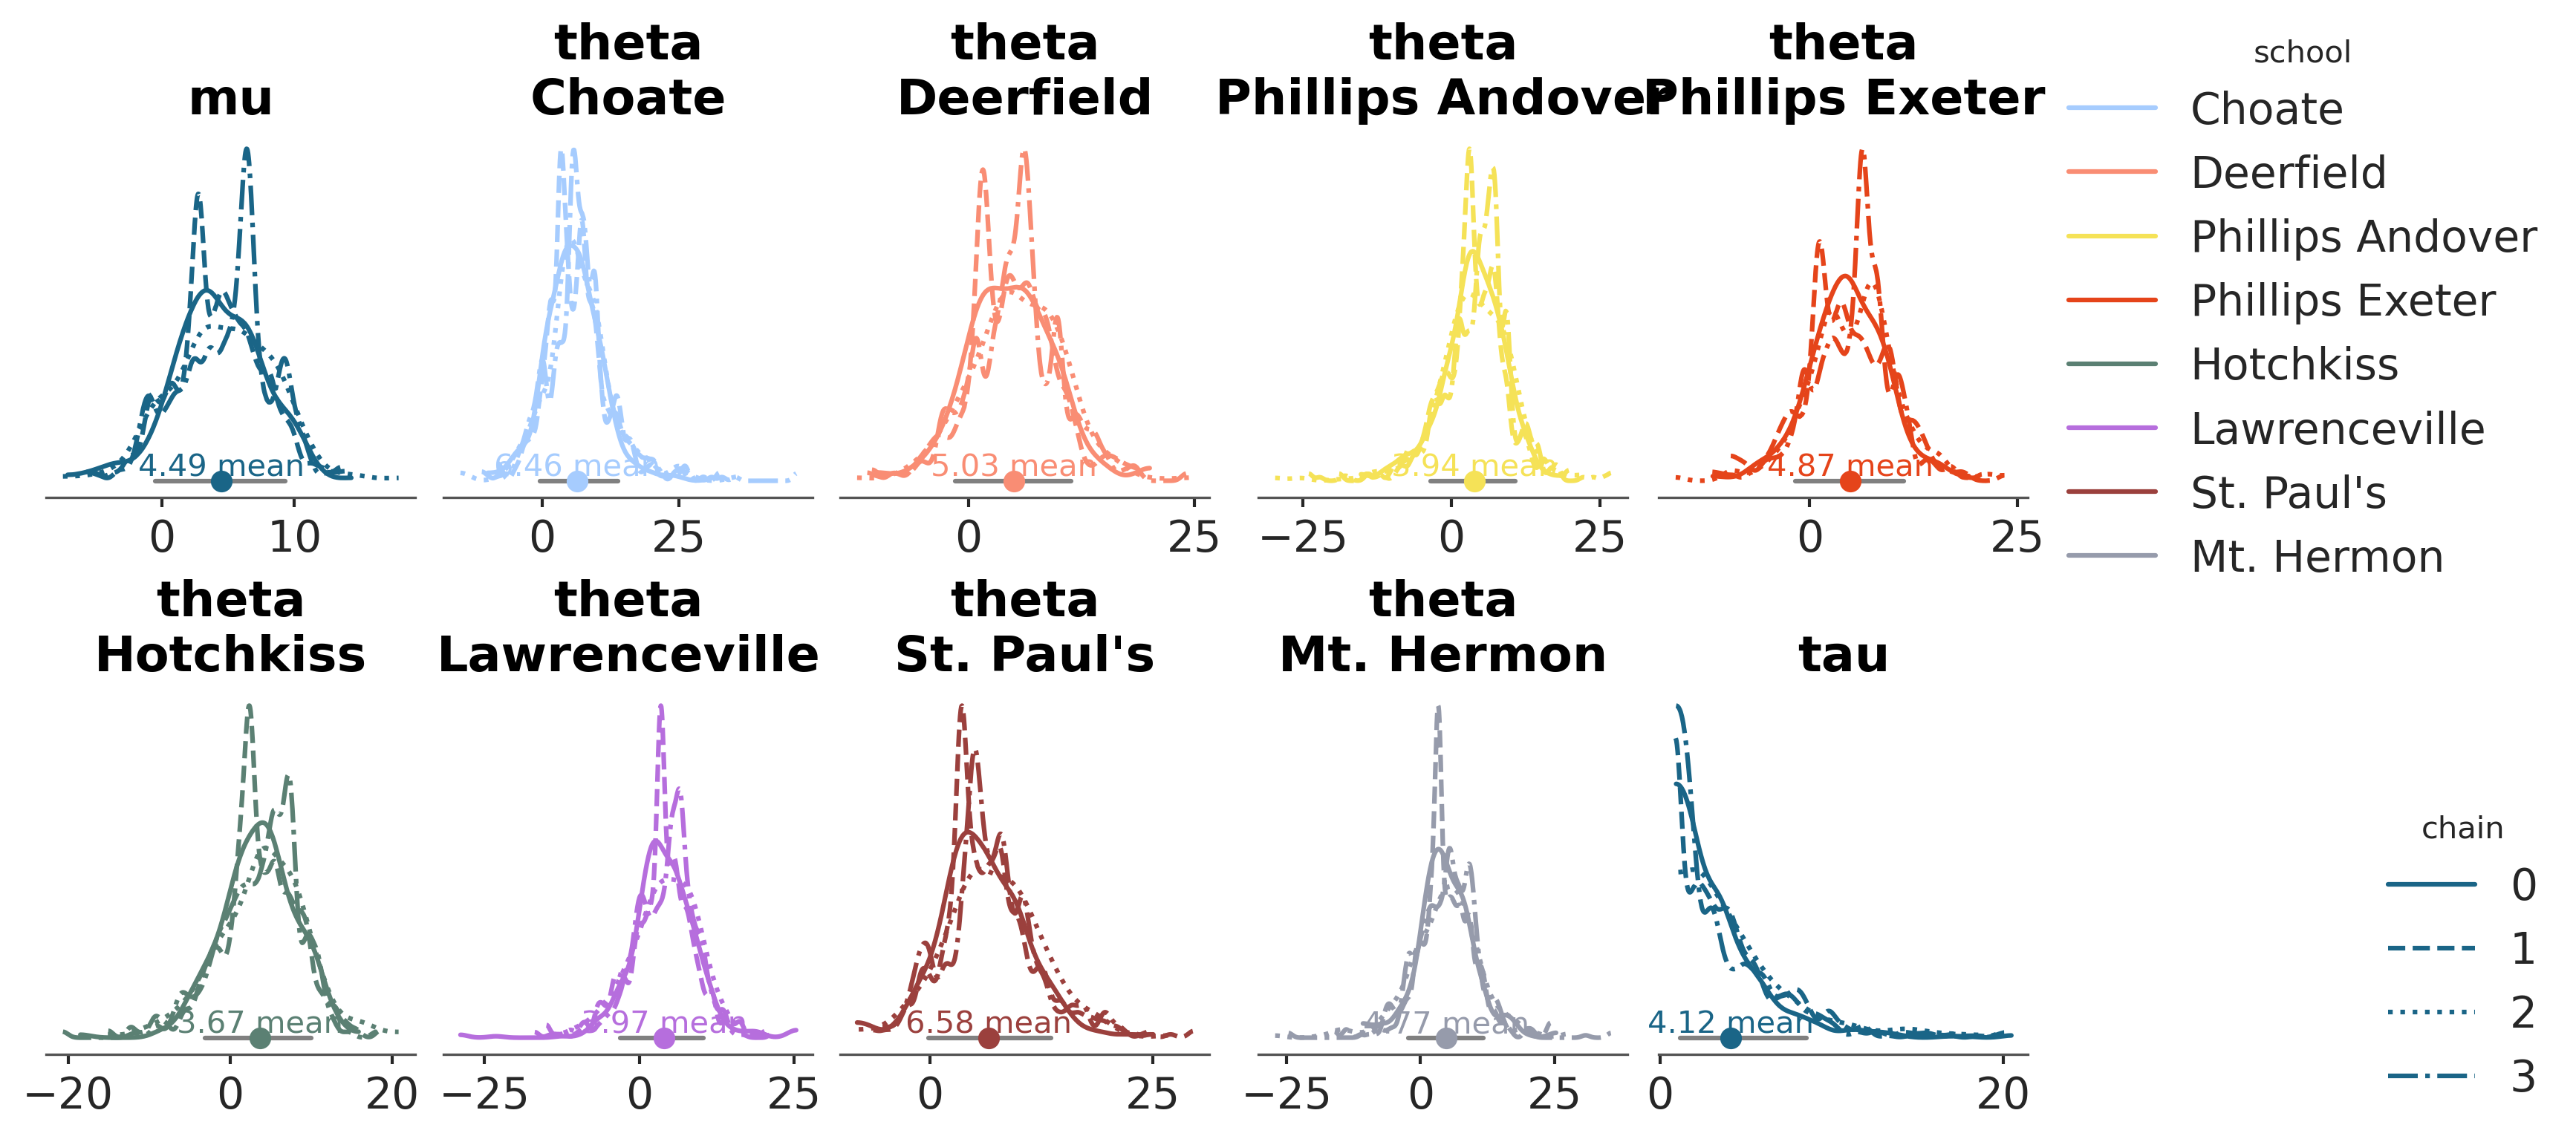

In [11]:
pc = azp.plot_dist(
    schools, 
    pc_kwargs={
        "aes": {"color": ["school"], "linestyle": ["chain"]},
        "plot_grid_kws": {"figsize": (12, 7)}
    },
    aes_map={"kde": ["color", "linestyle"], "point_estimate": ["color"]},
)
pc.add_legend("school", loc="outside right upper")
pc.add_legend("chain", loc="outside right lower");

## Advanced examples
So far we have called properties in which we encode aesthetics, and used color and linestyle as such properties. But `PlotCollection` only manages the mapping between a dataset property (in the form of a dimension) and a graphical property _with both key and values free to take anything_. The only limitation comes later when the mapped properties are passed down to the plotting function, these keys and values must be valid for the plotting function otherwise you'll get an error.

The functions used by `plot_dist` (and by other `plot_...` functions) aim to be somewhat general, so for example, `y` is a valid key for encoding information. But keep in mind that
if you want to generate plots significantly different from the default layout of `plot_dist` you'll need to follow the steps in {ref}`compose_own_plot` and use `PlotCollection` manually.

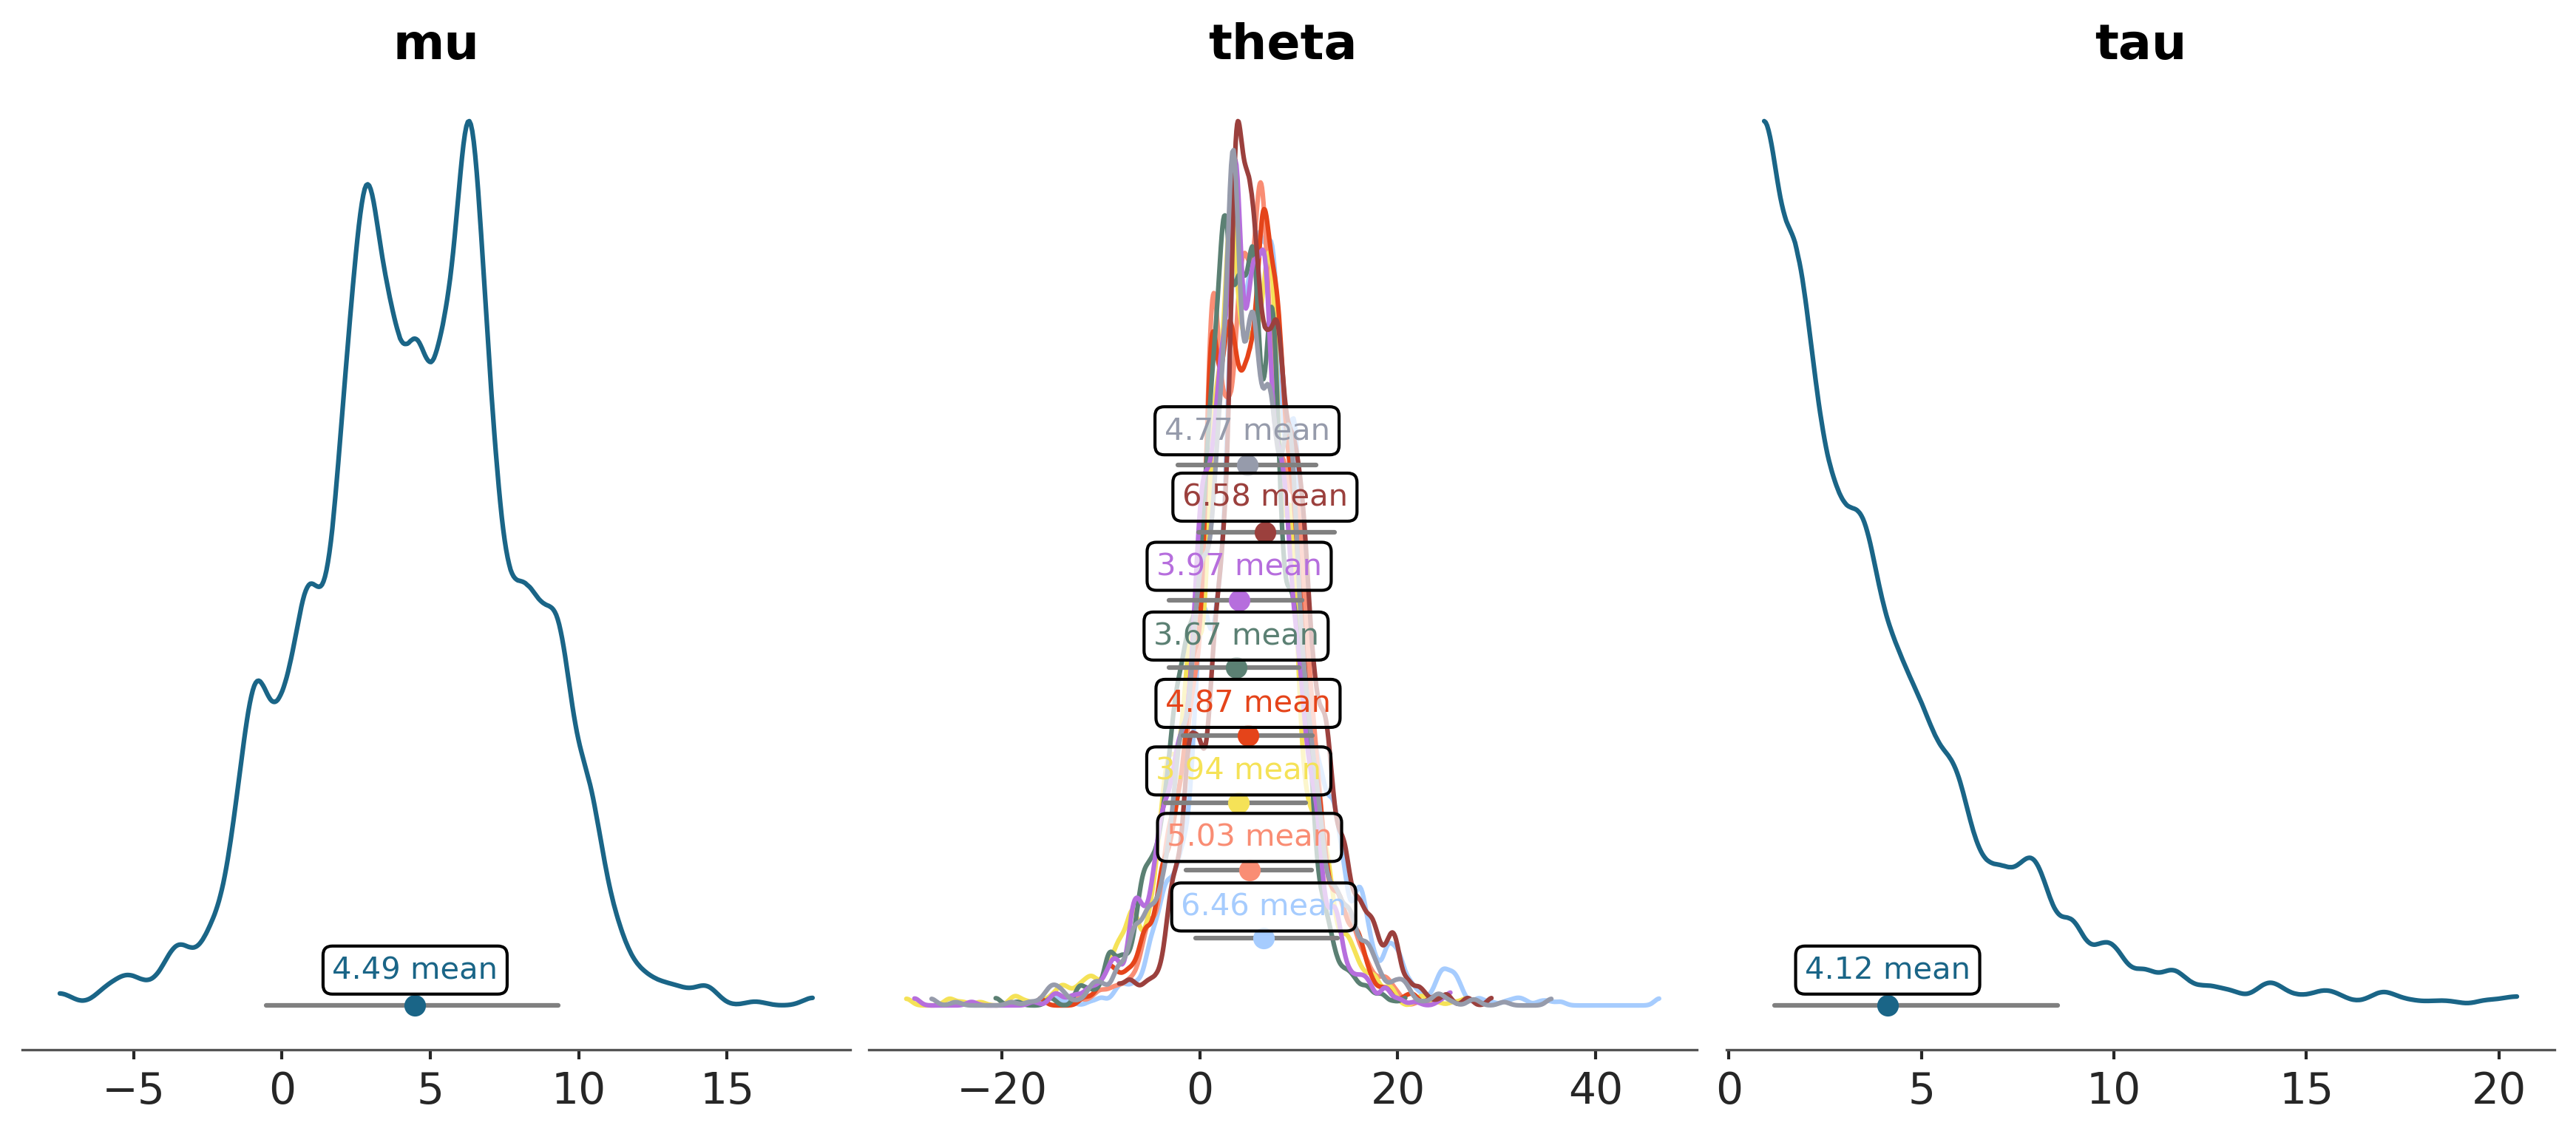

In [12]:
azp.plot_dist(
    schools, 
    pc_kwargs={
        # stop creating one subplot per variable *and* coordinate value,
        # generate only one per variable, in this case 3 subplots
        "cols": ["__variable__"],
        # encode the school informatin in both color and y properties
        "aes": {"color": ["school"], "y": ["school"]},
        "y": np.linspace(0, 0.06, 9),
    },
    aes_map={
        "kde": ["color"],
        "point_estimate": ["color", "y"],
        "credible_interval": ["y"]
    },
    plot_kwargs={"point_estimate_text": {"bbox": {"boxstyle": "round", "fc": (1, 1, 1, 0.7)}}},
);

We can have a range of variables with different shapes and dimensions, and as long as we are careful with the facetting and mapping arguments to not have them contradict each other,
the underlying `PlotCollection` used by `plot_dict` can combine all the different variables into a single plot, mapping the aesthetics provided only when relevant:

In [13]:
from arviz_base.datasets import REMOTE_DATASETS, RemoteFileMetadata
# TODO: remove this monkeypatching once the arviz_example_data repo has been updated
REMOTE_DATASETS.update({
    "rugby_field": RemoteFileMetadata(
        name="rugby_field",
        filename="rugby_field.nc",
        url="https://figshare.com/ndownloader/files/44667112",
        checksum="53a99da7ac40d82cd01bb0b089263b9633ee016f975700e941b4c6ea289a1fb0",
        description="""Variant of the rugby model."""
    )
})
rugby = load_arviz_data("rugby_field")

Here for example we have 4 variables: a two dimensional one, two with 3 dimensions (but different dimensions for their 3rd one) and one with 4 dimensions:

In [14]:
rugby.posterior.ds[["atts_team", "atts", "intercept", "sd_att"]]

<xarray.Dataset> Size: 340kB
Dimensions:    (chain: 4, draw: 500, team: 6, field: 2)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * field      (field) <U4 32B 'home' 'away'
  * team       (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
Data variables:
    atts_team  (chain, draw, team) float64 96kB ...
    atts       (chain, draw, field, team) float64 192kB ...
    intercept  (chain, draw, field) float64 32kB ...
    sd_att     (chain, draw) float64 16kB ...
Attributes:
    created_at:                 2024-02-23T20:21:03.016373
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              21.146891355514526
    tuning_steps:               1000

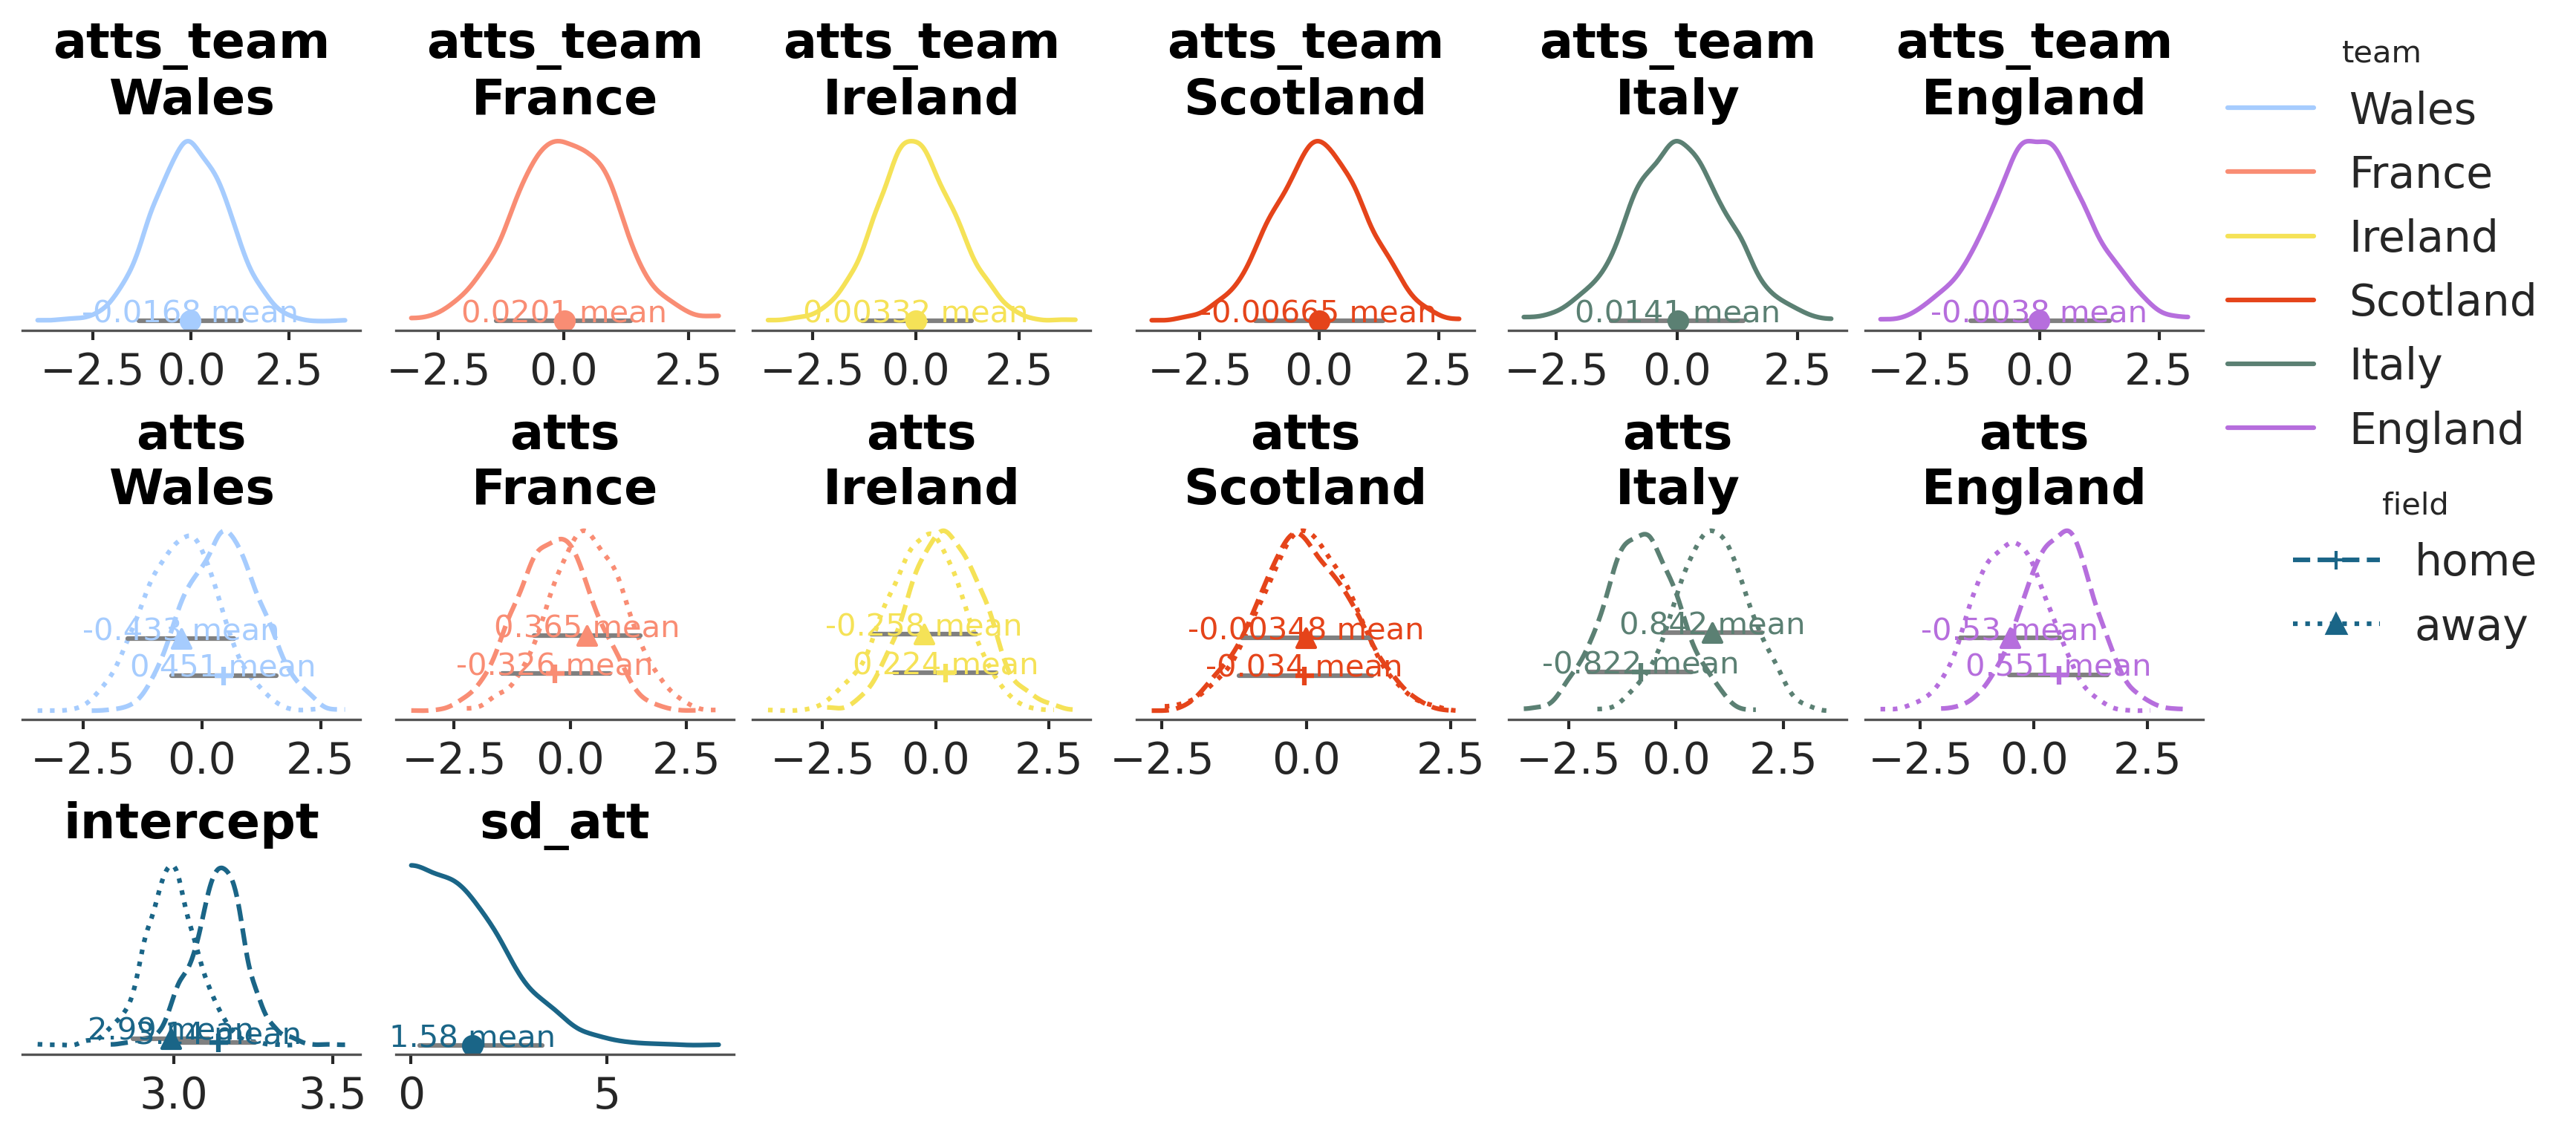

In [15]:
pc = azp.plot_dist(
    rugby,
    var_names=["atts_team", "atts", "intercept", "sd_att"],
    pc_kwargs={
        "cols": ["__variable__", "team"],
        "col_wrap": 6,
        "plot_grid_kws": {"figsize": (10, 6)},
        "aes": {
            "linestyle": ["field"],
            "color": ["team"],
            "marker": ["field"],
            "y": ["field"]
        },
        "y": [0, 0.1, 0.2]
    },
    aes_map={
        "kde": ["color", "linestyle"],
        "point_estimate": ["color", "marker", "y"],
        "point_estimate_text": ["color", "y"],
        "credible_interval": ["y"]
    },
)
pc.add_legend("team")
pc.add_legend("field", loc="outside right center");